In [1]:
#1. Check Tensorflow
import os
# if GPU is not available, just disable GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("AFDB_NSRDB_all.csv") > -1:
        filenames.append(filename)

In [2]:
filenames

['AFDB_NSRDB_all.csv']

In [3]:
# check available GPU
import tensorflow as tf

# uncomment if using tensorflow  2.x 
#tf.config.list_physical_devices('GPU') 

# uncomment if using tensorflow 1.x
with tf.Session() as sess:
    print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7262860107862095634)]


In [4]:
tf.__version__

'1.15.0'

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
#2. Load Dataset
ecg_dfs = pd.read_csv(dataset_folder + "AFDB_NSRDB_all.csv", header=None)

In [7]:
ecg_dfs.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,-0.005750,-0.000711,-0.001478,0.018078,0.005702,0.007844,0.012892,0.020847,0.023000,0.039675,...,0.038382,0.041877,0.030852,0.051757,0.043627,0.038399,0.024460,0.019229,0.031417,AF
1,0.572196,0.581230,0.559953,0.573305,0.577980,0.552318,0.548263,0.531158,0.531292,0.535653,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AF
2,0.945759,0.927736,0.919183,0.915354,0.944660,0.945494,0.936783,0.937449,0.933247,0.947827,...,0.012735,-0.000662,-0.014031,0.020003,0.011426,0.002877,-0.000907,0.019025,0.024772,AF
3,-0.012034,-0.003049,0.021547,0.007121,-0.022910,-0.013913,0.018508,0.004114,-0.010263,0.037822,...,0.029425,0.013561,0.091311,0.161222,0.254522,0.269756,0.277173,0.245559,0.245160,AF
4,0.314096,-0.134123,0.280946,0.572697,0.124505,0.046321,0.461478,1.000000,0.181966,0.350591,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AF


In [8]:
#3. Label Encoding
X = ecg_dfs.iloc[:,:3000].values
    
y = ecg_dfs.iloc[:,3000].values

le = LabelEncoder()
le.fit(y)

labels = le.classes_
print("categorical label : ", labels)

y = le.transform(y)

categorical label :  ['AF' 'N']


In [9]:
#4. Split Dataset
test_split_size = 0.33 # 33% for testing, 67% for train

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=test_split_size, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5666, 3000), (2792, 3000), (5666,), (2792,))

In [12]:
fs = 250 #Hz

In [13]:
#5. Add Noise AWGN
def add_AWGN_noise(signal, target_noise_db = -30):
    mean_noise = 0
    target_noise_watts = 10 ** (target_noise_db / 10)
    sigma = np.sqrt(target_noise_watts)
    
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [14]:
def plot_noised_signal(signal, noised_signal):
    time = np.arange(len(signal[0])) / fs
    
    plt.figure(figsize=(20,10)) 

    plt.subplot(2,1,1)
    plt.plot(time, signal[0])
    plt.plot(time, signal[1])
    plt.legend(['channel 1', 'channel 2'])
    plt.title("Original Signal")
    plt.grid()


    plt.subplot(2,1,2)
    plt.plot(time, noised_signal[0])
    plt.plot(time, noised_signal[1])
    plt.legend(['channel 1', 'channel 2'])
    plt.title("Noised Signal with AWGN")
    plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
# scale data from 0 to 1
def scaler(X):
    res = []
    for x in X :
        global_min = x.min()
        x = np.reshape(x, (2, 1500))
        for i in range(len(x)):
            idx = np.max(np.nonzero(x[i]))
            x[i][idx+1:] = global_min
        x = np.reshape(x, (3000))
        res.append((x - x.min())/(x.max() - x.min()))
    return np.array(res)

In [16]:
X_train = scaler(X_train)
X_test = scaler(X_test)

In [17]:
# apply noise to signal

X_train_noised = np.array([add_AWGN_noise(signal) for signal in X_train])
X_test_noised = np.array([add_AWGN_noise(signal) for signal in X_test])

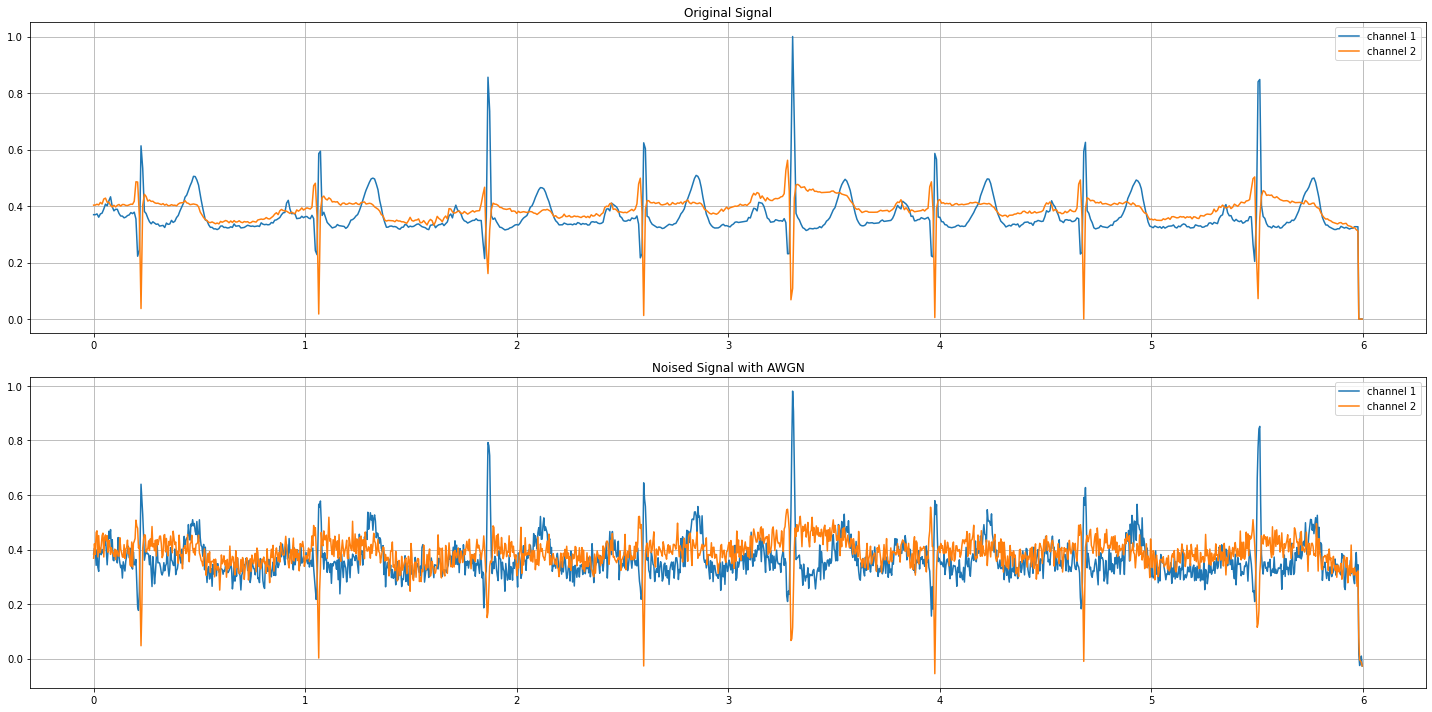

In [18]:
signal = np.reshape(X_train[0], (2, 1500))
noised_signal = np.reshape(X_train_noised[0], (2, 1500))

plot_noised_signal(signal, noised_signal)

In [19]:
def calc_snr(signal, noised_signal):
    
    noise = np.array(noised_signal - signal)
    std_noise = noise.std(axis=1)
    signal_avg = signal.mean(axis=1)
    
    SNR  =  np.where(signal_avg <= 0, 1, signal_avg/std_noise)
    SNR_db = 10*np.log(SNR)

    return SNR_db

In [20]:
def calc_psnr(signal, noised_signal, max_peak=1):
    noise = np.array(noised_signal - signal)
    mse = (np.square(signal - noise)).mean(axis=1)
    
    SNR = np.where(mse == 0, 0, max_peak/mse)
    SNR_db = 10*np.log(SNR)
    
    return SNR_db

In [21]:
print("------ SNR Noised Signal ------\n")
SNR_db = calc_snr(X_train, X_train_noised)
for i in range(len(X_train)):
    if i % int(len(X_train)/10) == 0:
        print('Sample %d \t : SNR %.4f db' % (i, SNR_db[i]))

------ SNR Noised Signal ------

Sample 0 	 : SNR 24.8125 db
Sample 566 	 : SNR 23.7651 db
Sample 1132 	 : SNR 23.1121 db
Sample 1698 	 : SNR 24.7090 db
Sample 2264 	 : SNR 27.6460 db
Sample 2830 	 : SNR 23.5728 db
Sample 3396 	 : SNR 24.4314 db
Sample 3962 	 : SNR 25.8429 db
Sample 4528 	 : SNR 25.5145 db
Sample 5094 	 : SNR 27.4480 db
Sample 5660 	 : SNR 26.8842 db


In [22]:
print("------ PSNR Noised Signal ------\n")
PSNR_db = calc_psnr(X_train, X_train_noised)
for i in range(len(X_train)):
    if i % int(len(X_train)/10) == 0:
        print('Sample %d \t : PSNR %.4f db' % (i, PSNR_db[i]))

------ PSNR Noised Signal ------

Sample 0 	 : PSNR 19.2552 db
Sample 566 	 : PSNR 20.7229 db
Sample 1132 	 : PSNR 21.2791 db
Sample 1698 	 : PSNR 18.9555 db
Sample 2264 	 : PSNR 11.8159 db
Sample 2830 	 : PSNR 20.9279 db
Sample 3396 	 : PSNR 19.4452 db
Sample 3962 	 : PSNR 16.9803 db
Sample 4528 	 : PSNR 17.5561 db
Sample 5094 	 : PSNR 13.9944 db
Sample 5660 	 : PSNR 14.6038 db


In [23]:
#Deoising Signal
def plot_model_history(history):
    
    fig, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss (RMSE)')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

In [24]:
def plot_decoded_signal(decoded_signal, original_signal, name):
    time = np.arange(len(decoded_signal[0])) / fs
    plt.figure(figsize=(20,10))

    plt.subplot(2,1,1)
    plt.plot(decoded_signal[0])
    plt.plot(decoded_signal[1])
    plt.title("Denoised Signal - " + name)
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(original_signal[0])
    plt.plot(original_signal[1])
    plt.title("Original Signal")
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.tight_layout()
    plt.show()

In [25]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [26]:
#Denoising CNN
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [27]:
from keras.layers import Conv1D, MaxPooling1D as MaxP1D, UpSampling1D as UpSm1D

In [28]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1], 1)
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1], 1)

In [29]:
def ConvAutoEncoder(input_dim):
    conv_net = Sequential(name="conv_autoencoder")
    #conv_net.add(InputLayer(input_shape=(input_dim,1))) 
    
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="encode_1", input_shape=(input_dim,1)))
    conv_net.add(MaxP1D(2, padding='same', name="encode_2"))
    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="encode_3"))
    conv_net.add(MaxP1D(2, padding='same', name="encode_4"))

    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="decode_3"))
    conv_net.add(UpSm1D(2, name="decode_4"))
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="decode_5"))
    conv_net.add(UpSm1D(2, name="decode_6"))
    conv_net.add(Conv1D(1, 3, activation='sigmoid', padding='same', name="decode_7"))

    conv_net.summary()
    
    conv_net.compile(
                    optimizer = 'adam', 
                    loss = rmse)
    
    return conv_net

In [30]:
def model_fit(model, name, X_train_noised, X_train,  X_test_noised, X_test, epochs = 10, batch_size = 32):
    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
                ModelCheckpoint(
                         filepath = "best_" + name, 
                         monitor = 'val_loss',
                         save_best_only = True)]

    return model.fit(X_train_noised, X_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = callbacks,
                    shuffle = True,
                    validation_data = (X_test_noised, X_test))

In [31]:
model_name_conv_AE = 'denoising_conv_AE.h5'

input_dim = X_train_noised.shape[1]
conv_autoencoder = ConvAutoEncoder(input_dim)

history =  model_fit(conv_autoencoder, 
                     model_name_conv_AE, 
                     X_train_noised, X_train,  
                     X_test_noised, X_test, 
                     epochs = 10, batch_size = 32)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (Conv1D)            (None, 3000, 128)         512       
_________________________________________________________________
encode_2 (MaxPooling1D)      (None, 1500, 128)         0         
_________________________________________________________________
encode_3 (Conv1D)            (None, 1500, 64)          24640     
_________________________________________________________________
encode_4 (MaxPooling1D)      (None, 750, 64)           0         
_________________________________________________________________
decode_3 (Conv1D)            (None, 750, 64)           12352     
_________________________________________________________________
decode_4 (UpSampling1D)      (None, 1500, 64)          0         
_________________________________________________________________
decode_5 (Conv1D)            (None, 1500, 128)         24704     
_______

In [32]:
conv_autoencoder.save(model_name_conv_AE)

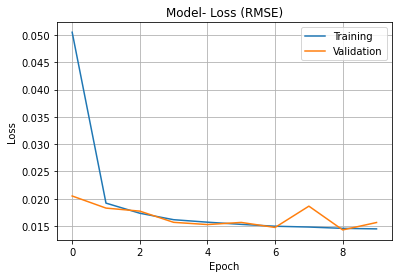

In [33]:
plot_model_history(history)

In [34]:
history_df = pd.DataFrame(history.history)

history_df.to_csv("history_Training_Denoising_Conv_AE.csv", index=False)

In [35]:
X_train_denoised = conv_autoencoder.predict(X_train_noised)

In [36]:
X_test_denoised = conv_autoencoder.predict(X_test_noised)

In [37]:
print("------ SNR Denoised Signal ConvAE------\n")
SNR_db = calc_snr(X_train, X_train_denoised)
for i in range(len(X_train)):
    if i % int(len(X_train)/10) == 0:
        print('Sample %d \t : SNR %.4f db' % (i, SNR_db[i]))

------ SNR Denoised Signal ConvAE------

Sample 0 	 : SNR 33.8044 db
Sample 566 	 : SNR 32.5379 db
Sample 1132 	 : SNR 31.7421 db
Sample 1698 	 : SNR 34.4804 db
Sample 2264 	 : SNR 34.7532 db
Sample 2830 	 : SNR 31.9808 db
Sample 3396 	 : SNR 34.0469 db
Sample 3962 	 : SNR 33.4690 db
Sample 4528 	 : SNR 33.8746 db
Sample 5094 	 : SNR 36.4170 db
Sample 5660 	 : SNR 35.6953 db


In [38]:
print("------ PSNR Noised Signal ConvAE------\n")
PSNR_db = calc_psnr(X_train, X_train_denoised)
for i in range(len(X_train)):
    if i % int(len(X_train)/10) == 0:
        print('Sample %d \t : PSNR %.4f db' % (i, PSNR_db[i]))

------ PSNR Noised Signal ConvAE------

Sample 0 	 : PSNR 18.9015 db
Sample 566 	 : PSNR 20.3707 db
Sample 1132 	 : PSNR 20.9240 db
Sample 1698 	 : PSNR 18.6050 db
Sample 2264 	 : PSNR 11.6083 db
Sample 2830 	 : PSNR 20.5338 db
Sample 3396 	 : PSNR 19.1011 db
Sample 3962 	 : PSNR 16.6600 db
Sample 4528 	 : PSNR 17.2370 db
Sample 5094 	 : PSNR 13.7338 db
Sample 5660 	 : PSNR 14.3424 db


In [39]:
X_train_denoised = X_train_denoised.reshape(len(X_train_denoised), X_train_denoised.shape[1])
X_test_denoised = X_test_denoised.reshape(len(X_test_denoised), X_test_denoised.shape[1])

train_denoised_df = pd.DataFrame(np.hstack((X_train_denoised, np.expand_dims(y_train, 1))))
train_denoised_df.to_csv(dataset_folder + "train_all_Conv_AE.csv", index=None, header=None)

test_denoised_df = pd.DataFrame(np.hstack((X_test_denoised, np.expand_dims(y_test, 1))))
test_denoised_df.to_csv(dataset_folder + "test_all_Conv_AE.csv", index=None, header=None)

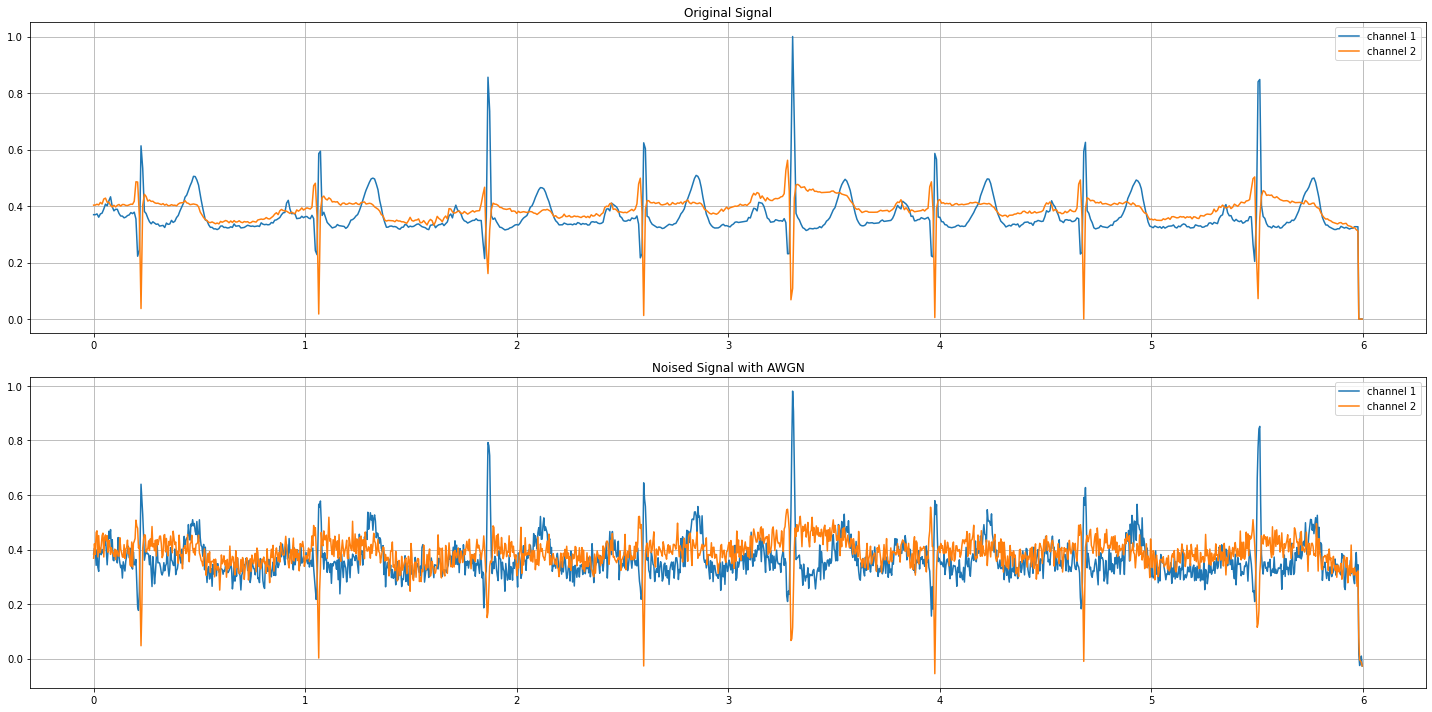

In [40]:
signal = np.reshape(X_train[0], (2, 1500))
noised_signal = np.reshape(X_train_noised[0], (2, 1500))

plot_noised_signal(signal, noised_signal)

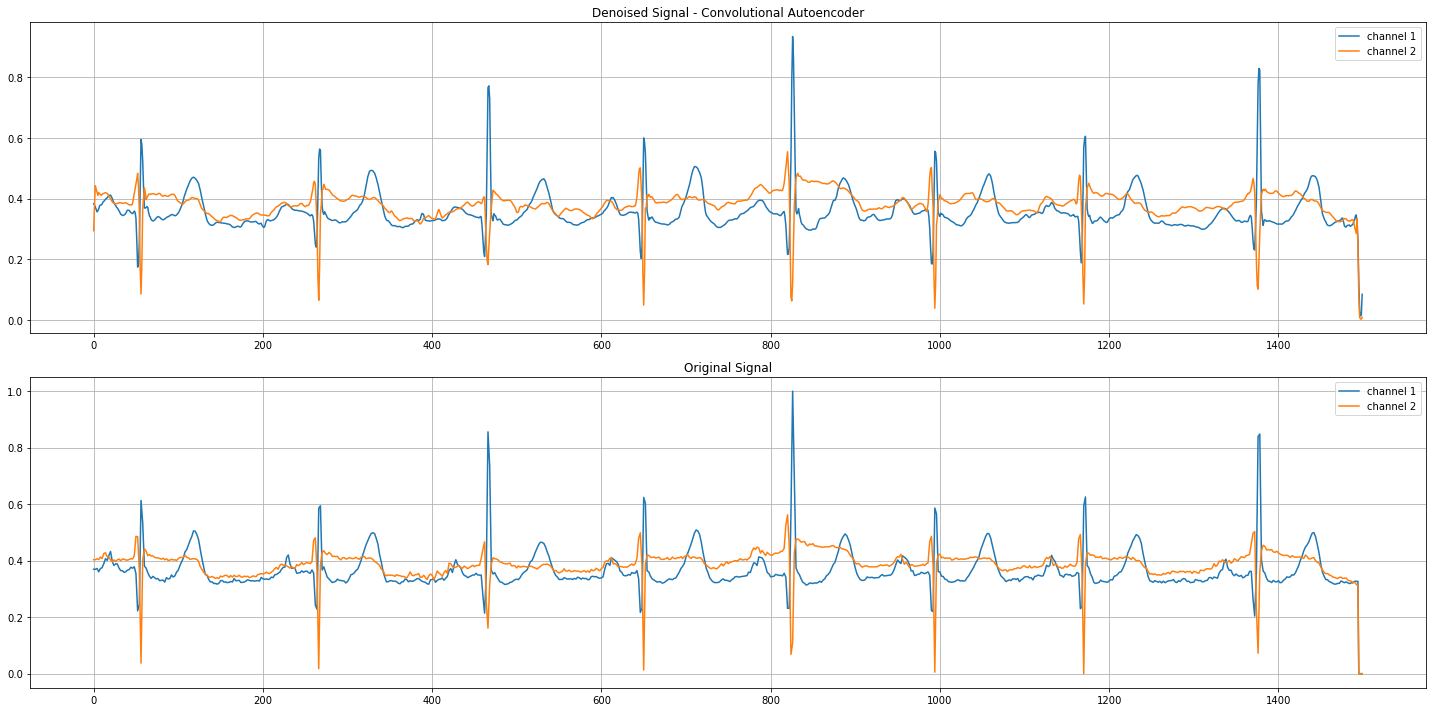

In [41]:
signal = np.reshape(X_train[0], (2, 1500))
denoised_signal = np.reshape(X_train_denoised[0], (2, 1500))

plot_decoded_signal(denoised_signal, signal,"Convolutional Autoencoder")